# ING Datathon 2025

Yarışmanın amacı, bir bankanın müşterilerinin referans tarihinden sonraki 6 aylık dönemde churn (müşteri kaybı) olasılıklarını tahmin etmektir. Bu 6 aylık dönem özellikle dikkat ettiğimiz zaman dilimi oldu; özellikleri geliştirirken son 6 aya yakın verileri daha yoğun kullandık.

RFM analizindeki temel metrikleri (Recency, Frequency, Monetary) parçalayarak ve detaylandırarak müşteri davranışlarını daha iyi anlamaya çalıştık. Problem, bir sınıflandırma modelinin churn olasılığını tahmin etmeyi gerektiriyordu. Bu amaçla CatBoost, Optuna ve AutoGluon gibi farklı modelleme yaklaşımlarını kullandık.

Cross-validation sürecimizde, veri setinin büyüklüğü nedeniyle 10-fold yaklaşımını benimsedik ve OOF (Out-of-Fold) metriklerini kullanarak modeli farklı yönlerden valide ettik. Final model seçiminde,cross-validation ortalaması, fold'lar arası olasılık değerlerinin dengeli olduğu, OOF ve public leaderboard skorlarında iyi performans gösteren modeller tercih ettik.

Yarışma zamanının büyük bir çoğunluğunu veri analizi ve özellik mühendisliği üzerine harcadık, çünkü ne kadar iyi bir modelleme mimarisi kursanız da, veri setiniz anlamlı ve domain'ini temsil etmedikten sonra maalesef olumlu sonuçlar çıkmamakta (Garbage in, Garbage out). <br>
Mevcut veri işleme ve özellik mühendisliği metodolojilerimizin sonucunda default bir CatBoost modelinde bile private'da 1.25155 skor elde edebilir hale geldik. 1.lik submission'ımız ise ensemble odaklı AutoGluon modellememizden geldi.

**DİKKAT:** AutoGluon modellememiz normalde V6e-1 ile 6 saat çalıştırılmıştı, Kaggle ortamında V6e-1 bulunmaması ve notebook'un daha hızlı çalışması için burada modellemesi 6 dakikaya indirilmiştir, bu nedenle sonuçlarda farklılık olabilir. (Detaylar **5. Modelleme** de bahsedilmiştir)

## İçindekiler
1. **Çalışma Ortamı Hazırlığı** <br>
2. **Giriş** <br>
  2.1 **Veri Seti Tanıtımı** <br>
  2.2 **Veri Analizi** <br>
3. **Train ve Test Veri setlerini Oluşturma** <br>
4. **Özellik Seçimi** <br>
  4.1 **Welch's T-test** <br>
  4.2 **Leave One Feature Out (LOFO)** <br>
5. **Modelleme** <br>
  5.1 **Default CatBoost** <br>
  5.2 **CatBoost Optuna Tuning** <br>
  5.3 **AutoGluon** <br>
6. **Test Verisini Tahminleme** <br>
7. **Denenen Ekstra Yöntemler ve Gözlemler** <br>

# 1. Çalışma Ortamı Hazırlığı

In [1]:
!pip install catboost optuna autogluon -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 21.0 MB/s et

In [5]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import roc_auc_score
# Surpress Warnings
import logging
import warnings
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)


DATA_PATH = "/kaggle/input/ing-hubs-turkiye-datathon/"
REFERANCE_DATA_PATH = DATA_PATH+"referance_data.csv"
REFERANCE_TEST_DATA_PATH = DATA_PATH+"referance_data_test.csv"
CUSTOMERS_DATA_PATH = DATA_PATH+"customers.csv"
CUSTOMERS_HISTORY_DATA_PATH = DATA_PATH+"customer_history.csv"

referance_train_df = pd.read_csv(REFERANCE_DATA_PATH)
referance_test_df = pd.read_csv(REFERANCE_TEST_DATA_PATH)
customers_df = pd.read_csv(CUSTOMERS_DATA_PATH)
customers_hist_df = pd.read_csv(CUSTOMERS_HISTORY_DATA_PATH)

USE_GPU = False # Final submission'da AutoGluon en iyi skoru getirdiği için onu en verimli çalıştıran TPU'yu kullanıyoruz, CatBoost odaklı gitmek için GPU daha verimli olacaktır

In [9]:
%%writefile custom_score.py

import numpy as np
from sklearn.metrics import roc_auc_score

def ing_hubs_datathon_metric(y_true, y_prob):
    """
    Gini, recall@10% ve lift@10% metriklerini birleştiren özel bir metrik hesaplar.

    Metrik, her bir skoru bir baseline modelin metrik değerlerine göre oranlar ve aşağıdaki ağırlıkları uygular:
    - Gini: %40
    - Recall@10%: %30
    - Lift@10%: %30

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.

    Döndürür:
        float: Ağırlıklandırılmış bileşik skor.
    """
    def recall_at_k(y_true, y_prob, k=0.1):
        """
        Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek recall değerini hesaplar.

        Parametreler:
            y_true (list): Gerçek ikili etiketler.
            y_prob (list): Tahmin edilen olasılıklar.
            k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

        Döndürür:
            float: En iyi k% tahminlerindeki recall oranı.
        """
        y_true = np.asarray(y_true)
        y_prob = np.asarray(y_prob)
        n = len(y_true)
        m = max(1, int(np.round(k * n)))
        order = np.argsort(-y_prob, kind="mergesort")
        top = order[:m]

        tp_at_k = y_true[top].sum()
        P = y_true.sum()
        return float(tp_at_k / P) if P > 0 else 0.0

    def lift_at_k(y_true, y_prob, k=0.1):
        """
        Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek lift (precision/prevalence) değerini hesaplar.

        Parametreler:
            y_true (list): Gerçek ikili etiketler.
            y_prob (list): Tahmin edilen olasılıklar.
            k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

        Döndürür:
            float: En iyi k% tahminlerindeki lift değeri.
        """
        y_true = np.asarray(y_true)
        y_prob = np.asarray(y_prob)
        n = len(y_true)
        m = max(1, int(np.round(k * n)))
        order = np.argsort(-y_prob, kind="mergesort")
        top = order[:m]

        tp_at_k = y_true[top].sum()
        precision_at_k = tp_at_k / m
        prevalence = y_true.mean()
        return float(precision_at_k / prevalence) if prevalence > 0 else 0.0


    def convert_auc_to_gini(auc):
        """
        ROC AUC skorunu Gini katsayısına dönüştürür.

        Gini katsayısı, ROC AUC skorunun doğrusal bir dönüşümüdür.

        Parametreler:
            auc (float): ROC AUC skoru (0 ile 1 arasında).

        Döndürür:
            float: Gini katsayısı (-1 ile 1 arasında).
        """
        return 2 * auc - 1

    # final metrik için ağırlıklar
    score_weights = {
        "gini": 0.4,
        "recall_at_10perc": 0.3,
        "lift_at_10perc": 0.3,
    }

    # baseline modelin her bir metrik için değerleri
    baseline_scores = {
        "roc_auc": 0.6925726757936908,
        "recall_at_10perc": 0.18469015795868773,
        "lift_at_10perc": 1.847159286784029,
    }

    # y_prob tahminleri için metriklerin hesaplanması
    roc_auc = roc_auc_score(y_true, y_prob)
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {
        "roc_auc": roc_auc,
        "recall_at_10perc": recall_at_10perc,
        "lift_at_10perc": lift_at_10perc,
    }

    # roc auc değerlerinin gini değerine dönüştürülmesi
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])

    # baseline modeline oranlama
    final_gini_score = new_scores["gini"] / baseline_scores["gini"]
    final_recall_score = new_scores["recall_at_10perc"] / baseline_scores["recall_at_10perc"]
    final_lift_score = new_scores["lift_at_10perc"] / baseline_scores["lift_at_10perc"]

    # ağırlıklandırılmış metriğin hesaplanması
    final_score = (
        final_gini_score * score_weights["gini"] +
        final_recall_score * score_weights["recall_at_10perc"] +
        final_lift_score * score_weights["lift_at_10perc"]
    )
    return final_score

Writing custom_score.py


# 2. Giriş

## 2.1 Veri Seti Tanıtımı

In [ ]:
for name, df in [
    ("Train Ref", referance_train_df),
    ("Test Ref", referance_test_df),
    ("Customers", customers_df),
    ("Customer History", customers_hist_df)
]:
    print(f"{name} şekli:", df.shape)
    print(f"{name} sütunları:", df.columns.tolist())
    print("-"*40)

Train Ref şekli: (133287, 3)
Train Ref sütunları: ['cust_id', 'ref_date', 'churn']
----------------------------------------
Test Ref şekli: (43006, 2)
Test Ref sütunları: ['cust_id', 'ref_date']
----------------------------------------
Customers şekli: (176293, 8)
Customers sütunları: ['cust_id', 'gender', 'age', 'province', 'religion', 'work_type', 'work_sector', 'tenure']
----------------------------------------
Customer History şekli: (5359609, 7)
Customer History sütunları: ['cust_id', 'date', 'mobile_eft_all_cnt', 'active_product_category_nbr', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']
----------------------------------------


Ortak sütun cust_id olacak

In [ ]:
print(referance_train_df.head(3))
print(referance_test_df.head(3))

   cust_id    ref_date  churn
0        0  2017-09-01      0
1        3  2018-10-01      0
2        5  2018-03-01      1
   cust_id    ref_date
0        1  2019-02-01
1        2  2019-01-01
2        9  2019-03-01


Train referans tablosu (referance_train_df):
* Her müşteri için cust_id, ref_date ve churn etiketi bulunuyor.
churn değeri modeli eğitmek için kullanılacak.

Test referans tablosu (referance_test_df):
* Sadece cust_id ve ref_date içeriyor.
Bu kayıtlar üzerinde churn tahminleri yapılacak.

In [ ]:
customers_df.head(3)

,cust_id,gender,age,province,religion,work_type,work_sector,tenure
0,0,F,64,NOH,U,Part-time,Technology,135
1,1,F,57,ZUI,O,Full-time,Finance,65
2,2,F,62,NOB,M,Self-employed,Healthcare,224


In [ ]:
customers_df.isnull().sum()

cust_id            0
gender             0
age                0
province           0
religion           0
work_type          0
work_sector    30134
tenure             0
dtype: int64

customers_df:
* Her müşteri için cust_id, gender, age, province, religion, work_type, work_sector ve tenure bilgilerini içeriyor.
* İş sektörü bilgilerinde boş olanlar mevcut.
* Bunları Unknown olarak doldurabiliriz.

In [ ]:
print(customers_hist_df.head(3))

   cust_id        date  mobile_eft_all_cnt  active_product_category_nbr  \
0        0  2016-01-01                 1.0                            2   
1        0  2016-02-01                 1.0                            2   
2        0  2016-03-01                 2.0                            2   

   mobile_eft_all_amt  cc_transaction_all_amt  cc_transaction_all_cnt  
0              151.20                     NaN                     NaN  
1              178.70                     NaN                     NaN  
2               37.38                     NaN                     NaN  


In [ ]:
customers_hist_df.isnull().sum()

cust_id                             0
date                                0
mobile_eft_all_cnt             112334
active_product_category_nbr         0
mobile_eft_all_amt             112334
cc_transaction_all_amt         166746
cc_transaction_all_cnt         166746
dtype: int64

In [ ]:
# Her ikisi de boş olan satırlar
null_rows = customers_hist_df[
    customers_hist_df['cc_transaction_all_amt'].isnull() &
    customers_hist_df['cc_transaction_all_cnt'].isnull()
]

# İlk 2 satırı yazdır
print(null_rows.head(2))

   cust_id        date  mobile_eft_all_cnt  active_product_category_nbr  \
0        0  2016-01-01                 1.0                            2   
1        0  2016-02-01                 1.0                            2   

   mobile_eft_all_amt  cc_transaction_all_amt  cc_transaction_all_cnt  
0               151.2                     NaN                     NaN  
1               178.7                     NaN                     NaN  


customers_hist_df:
* Her müşteri (cust_id) için zamana bağlı (date) işlem ve ürün bilgilerini içeriyor:
mobile_eft_all_cnt, mobile_eft_all_amt
cc_transaction_all_cnt, cc_transaction_all_amt
active_product_category_nbr
* cc transaction sayısı boş olduğunda amount da boş, bunları final datamızda sıfır olarak değerlendirebiliriz

### Ortak çıkarımlar:
* Ortak sütun: cust_id
* customers_df ve customer_history, hem train hem test setindeki müşteri bilgilerini içeriyor.
* Bu iki tabloyu cust_id üzerinden referans verileriyle birleştirebiliriz.

In [ ]:
def merge_customer_history(ref_df, hist_df, cust_df):
    """
    Customer history ve demografik bilgileri referans verisiyle birleştirir.

    ref_df  : referans dataframe
    hist_df : customer history dataframe
    cust_df : customer dataframe
    """
    merged_df = (
        hist_df[hist_df['cust_id'].isin(ref_df['cust_id'])]
        .merge(ref_df, on='cust_id', how='left')
        .merge(cust_df, on='cust_id', how='left')
    )
    return merged_df

In [ ]:
# Sadece train referansında bulunan customer_history kayıtları
train_full = merge_customer_history(referance_train_df, customers_hist_df, customers_df)
train_full.head()

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,churn,gender,age,province,religion,work_type,work_sector,tenure
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135


In [ ]:
# Sadece test referansında bulunan customer_history kayıtları
test_full = merge_customer_history(referance_test_df, customers_hist_df, customers_df)
test_full.head()

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,gender,age,province,religion,work_type,work_sector,tenure
0,1,2016-01-01,5.0,3,38.36,241.43,12.0,2019-02-01,F,57,ZUI,O,Full-time,Finance,65
1,1,2016-02-01,1.0,3,83.03,158.73,15.0,2019-02-01,F,57,ZUI,O,Full-time,Finance,65
2,1,2016-03-01,1.0,3,18.99,94.21,17.0,2019-02-01,F,57,ZUI,O,Full-time,Finance,65
3,1,2016-04-01,1.0,3,25.63,19.26,3.0,2019-02-01,F,57,ZUI,O,Full-time,Finance,65
4,1,2016-05-01,1.0,3,12.00,20.02,12.0,2019-02-01,F,57,ZUI,O,Full-time,Finance,65


### Test Seti Hazırlığı Notu
* Test verisi için, demografik bilgiler (customers_df) ve referans tarihleri (referance_test_df) ile müşteri geçmiş işlemleri (customers_hist_df) birleştirildi.
* Artık her müşteri için geçmiş işlem trendlerini, demografik özellikleri ve referans tarihlerini aynı tabloda görebiliyoruz.
* Bu birleşik tablo üzerinden sütunlar arasındaki ilişkileri ve churn davranışını inceleyebiliriz (train seti için).

## 2.2 Veri Analizi

In [ ]:
# Train için
train_counts = train_full['cust_id'].value_counts()
print("Train - En az kayıt sayısı :", train_counts.min())
print("Train - En fazla kayıt sayısı :", train_counts.max())

print("\n" + "*" * 25 + "\n")

# Test için
test_counts = test_full['cust_id'].value_counts()
print("Test  - En az kayıt sayısı :", test_counts.min())
print("Test  - En fazla kayıt sayısı :", test_counts.max())

Train - En az kayıt sayısı : 19
Train - En fazla kayıt sayısı : 36

*************************

Test  - En az kayıt sayısı : 37
Test  - En fazla kayıt sayısı : 42


Müşteri Veri Geçmişi

* Train setinde: Müşteriler 19 ila 36 adet geçmiş kayda sahip.
* Test setinde: Müşteriler 37 ila 42 kayıtla temsil ediliyor.
* Müşteri verileri yeterince eskiye dayanıyor, geçmiş davranış analizleri için kullanılabilir.

#### İlk Korelasyon Gözlemi

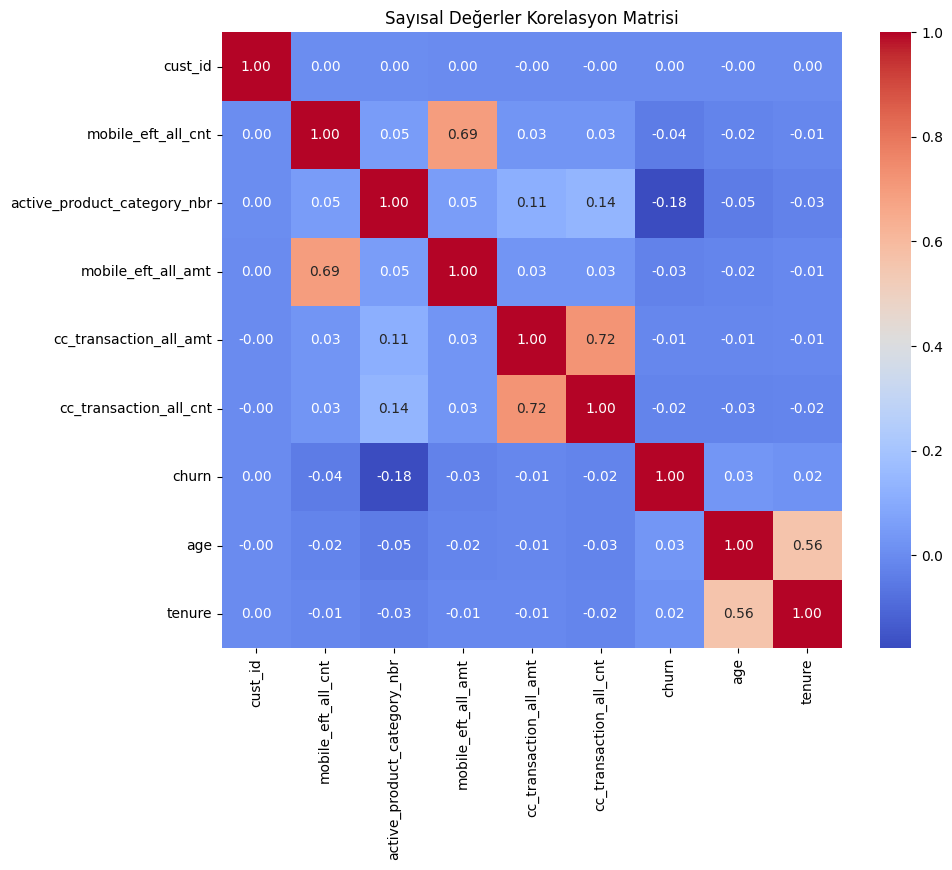

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sayısal sütunları seç
num_cols = train_full.select_dtypes(include=['int64', 'float64']).columns

# Korelasyon matrisi
corr_matrix = train_full[num_cols].corr()

# Isı haritası ile görselleştirme
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Sayısal Değerler Korelasyon Matrisi")
plt.show()

* Henüz müşteri başına gruplama yapılmadı; yani her satır bir cust_id–date kombinasyonu.
* Sayısal sütunlar arasındaki korelasyona baktığımızda; active_product_category_nbr, churn ile en yüksek ilişkiye sahip gibi görünüyor.

### Ürün Özeti ve Churn Korelasyonu Notu

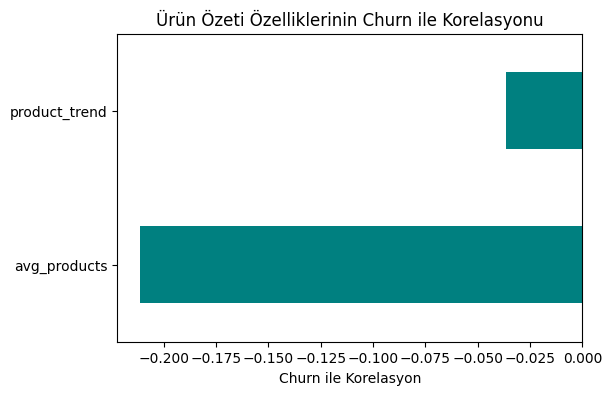

In [ ]:
# Özet özelliklerin oluşturulması
df = train_full.copy()
hist = customers_hist_df.copy()

# --- total_products ---
temp = hist.groupby('cust_id')['active_product_category_nbr'].sum().reset_index()
temp.columns = ['cust_id', 'total_products']
df = df.merge(temp, on='cust_id', how='left')

# --- avg_products ---
temp = hist.groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
temp.columns = ['cust_id', 'avg_products']
df = df.merge(temp, on='cust_id', how='left')

# --- product_trend ---
temp_last = hist.sort_values('date').groupby('cust_id').tail(1)[['cust_id', 'active_product_category_nbr']].reset_index(drop=True)
temp_last.columns = ['cust_id', 'last_prod']

temp_avg = hist.groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
temp_avg.columns = ['cust_id', 'avg_prod']

temp = temp_last.merge(temp_avg, on='cust_id', how='outer')
temp['product_trend'] = temp['last_prod'] - temp['avg_prod']
df = df.merge(temp[['cust_id', 'product_trend']], on='cust_id', how='left')

# Korelasyon matrisi
corr_cols = ['avg_products', 'product_trend', 'churn']
corr_matrix = df[corr_cols].corr()

# Sadece churn ile korelasyon
corr_with_churn = df[corr_cols].corr()['churn'].drop('churn')

# Çubuk grafiği
plt.figure(figsize=(6,4))
corr_with_churn.sort_values().plot(kind='barh', color='teal')
plt.xlabel("Churn ile Korelasyon")
plt.title("Ürün Özeti Özelliklerinin Churn ile Korelasyonu")
plt.show()

* avg_products churn ile diğer özet özelliklere göre daha yüksek korelasyona sahip.
* Ek olarak, **son dönem** ürün verilerini de kullanarak model performansı iyileştirilebilir.

### İşlem Metrikleri ve Churn Korelasyonu Notu

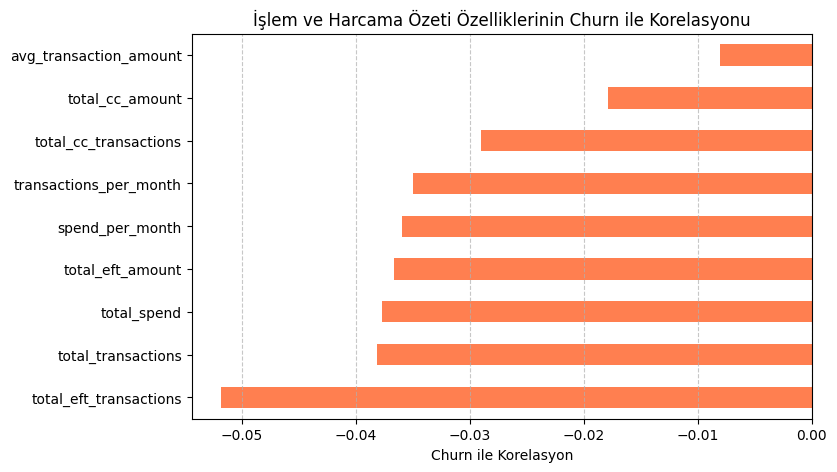

In [ ]:
# Kopya oluştur
df = train_full.copy()
hist = customers_hist_df.copy()

# --- total_transactions ---
temp = hist.groupby('cust_id').agg(
    eft=('mobile_eft_all_cnt', 'sum'),
    cc=('cc_transaction_all_cnt', 'sum')
).reset_index()
temp['total_transactions'] = temp['eft'] + temp['cc']
df = df.merge(temp[['cust_id', 'total_transactions']], on='cust_id', how='left')

# --- transactions_per_month ---
temp = hist.groupby('cust_id').agg(
    total_trans=('mobile_eft_all_cnt', 'sum'),
    total_cc=('cc_transaction_all_cnt', 'sum'),
    months=('date', 'nunique')
).reset_index()
temp['transactions_per_month'] = (temp['total_trans'] + temp['total_cc']) / (temp['months'] + 1e-6)
df = df.merge(temp[['cust_id', 'transactions_per_month']], on='cust_id', how='left')

# --- total_eft_transactions ---
temp = hist.groupby('cust_id')['mobile_eft_all_cnt'].sum().reset_index()
temp.columns = ['cust_id', 'total_eft_transactions']
df = df.merge(temp, on='cust_id', how='left')

# --- total_cc_transactions ---
temp = hist.groupby('cust_id')['cc_transaction_all_cnt'].sum().reset_index()
temp.columns = ['cust_id', 'total_cc_transactions']
df = df.merge(temp, on='cust_id', how='left')

# --- total_spend ---
temp = hist.groupby('cust_id').agg(
    eft_amt=('mobile_eft_all_amt', 'sum'),
    cc_amt=('cc_transaction_all_amt', 'sum')
).reset_index()
temp['total_spend'] = temp['eft_amt'] + temp['cc_amt']
df = df.merge(temp[['cust_id', 'total_spend']], on='cust_id', how='left')

# --- avg_transaction_amount ---
temp = hist.groupby('cust_id').agg(
    total_amt=('mobile_eft_all_amt', 'sum'),
    total_cc_amt=('cc_transaction_all_amt', 'sum'),
    total_cnt=('mobile_eft_all_cnt', 'sum'),
    total_cc_cnt=('cc_transaction_all_cnt', 'sum')
).reset_index()
temp['avg_transaction_amount'] = (temp['total_amt'] + temp['total_cc_amt']) / (temp['total_cnt'] + temp['total_cc_cnt'] + 1e-6)
df = df.merge(temp[['cust_id', 'avg_transaction_amount']], on='cust_id', how='left')

# --- spend_per_month ---
temp = hist.groupby('cust_id').agg(
    total_amt=('mobile_eft_all_amt', 'sum'),
    total_cc_amt=('cc_transaction_all_amt', 'sum'),
    months=('date', 'nunique')
).reset_index()
temp['spend_per_month'] = (temp['total_amt'] + temp['total_cc_amt']) / (temp['months'] + 1e-6)
df = df.merge(temp[['cust_id', 'spend_per_month']], on='cust_id', how='left')

# --- total_eft_amount ---
temp = hist.groupby('cust_id')['mobile_eft_all_amt'].sum().reset_index()
temp.columns = ['cust_id', 'total_eft_amount']
df = df.merge(temp, on='cust_id', how='left')

# --- total_cc_amount ---
temp = hist.groupby('cust_id')['cc_transaction_all_amt'].sum().reset_index()
temp.columns = ['cust_id', 'total_cc_amount']
df = df.merge(temp, on='cust_id', how='left')

# Churn ile korelasyon
corr_cols = ['total_transactions', 'transactions_per_month', 'total_eft_transactions',
             'total_cc_transactions', 'total_spend', 'avg_transaction_amount',
             'spend_per_month', 'total_eft_amount', 'total_cc_amount', 'churn']

# Sadece churn ile korelasyon
corr_with_churn = df[corr_cols].corr()['churn'].iloc[:-1].sort_values()

# Çubuk grafiği
plt.figure(figsize=(8,5))
corr_with_churn.plot(kind='barh', color='coral')
plt.xlabel("Churn ile Korelasyon")
plt.title("İşlem ve Harcama Özeti Özelliklerinin Churn ile Korelasyonu")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

* Genel işlem ve harcama metriklerinin korelasyonu, active_product_category_nbr kadar yüksek değil.
* Ancak son dönem metrikleri ile birlikte kullanıldığında, churn olasılığını daha iyi tahmin edecek anlamlı özellikler ortaya çıkarılabilir.

### Cinsiyet

In [ ]:
# --- Gender ---
gender_churn = customers_df.merge(referance_train_df[['cust_id', 'churn']], on='cust_id', how='inner') \
                           .groupby('gender')['churn'].mean().reset_index()
gender_churn.columns = ['gender', 'churn_rate']
print("--- Gender ---")
print(gender_churn)
print("\n")

--- Gender ---
  gender  churn_rate
0      F    0.140912
1      M    0.142270




* Anlamlı bir farklılık durmuyor

### Yaş

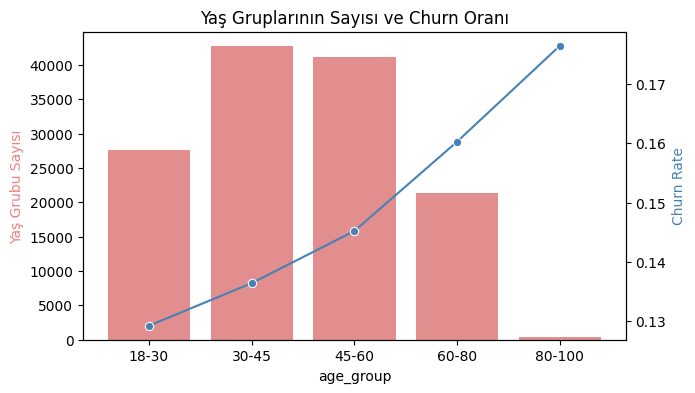

In [ ]:
# Bin ages and merge churn
bins = [18, 30, 45, 60, 80, 100]
labels = ['18-30', '30-45', '45-60', '60-80', '80-100']
age_churn = customers_df.merge(referance_train_df[['cust_id', 'churn']], on='cust_id')
age_churn['age_group'] = pd.cut(age_churn['age'], bins=bins, labels=labels, right=False)

# Group churn and count
summary = age_churn.groupby('age_group').agg(churn_rate=('churn','mean'), count=('cust_id','size')).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(7,4))

# Count as bar
sns.barplot(data=summary, x='age_group', y='count', color='lightcoral', ax=ax1)
ax1.set_ylabel('Yaş Grubu Sayısı', color='lightcoral')

# Churn rate as line
ax2 = ax1.twinx()
sns.lineplot(data=summary, x='age_group', y='churn_rate', color='steelblue', marker='o', ax=ax2)
ax2.set_ylabel('Churn Rate', color='steelblue')

plt.title("Yaş Gruplarının Sayısı ve Churn Oranı")
plt.show()

* Yaş gruplarında anlamlı farklar gözlemleniyor; yaş ilerledikçe churn oranı artıyor.

### Province

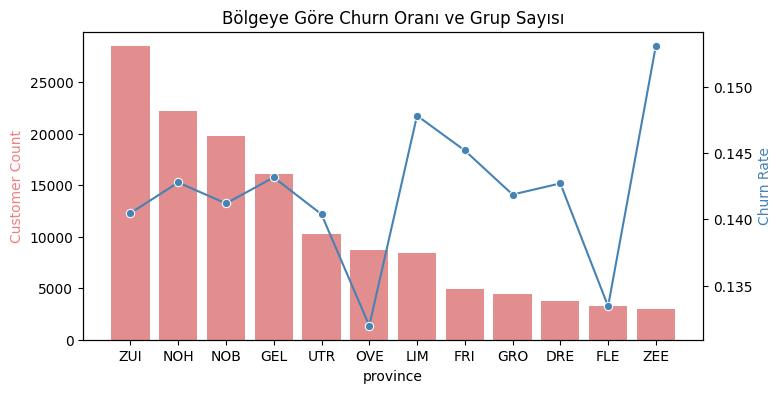

In [ ]:
# Province churn + counts
province_churn = (
    customers_df.merge(referance_train_df[['cust_id','churn']], on='cust_id')
    .groupby('province')
    .agg(churn_rate=('churn','mean'), count=('cust_id','size'))
    .reset_index()
    .sort_values('count', ascending=False)
)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# Customer count as bar
sns.barplot(data=province_churn, x='province', y='count', color='lightcoral', ax=ax1)
ax1.set_ylabel('Customer Count', color='lightcoral')

# Churn rate as line
ax2 = ax1.twinx()
sns.lineplot(data=province_churn, x='province', y='churn_rate', color='steelblue', marker='o', ax=ax2)
ax2.set_ylabel('Churn Rate', color='steelblue')

plt.title("Bölgeye Göre Churn Oranı ve Grup Sayısı")
plt.show()


* İl bazında churn oranları diğer özellikler kadar belirgin farklar göstermiyor.
* Ancak bu bilgileri diğer sütunlarla kombinleyerek veya modelin öğrenmesine izin vererek anlamlı sonuçlar elde etmek mümkün olabilir.

### Din

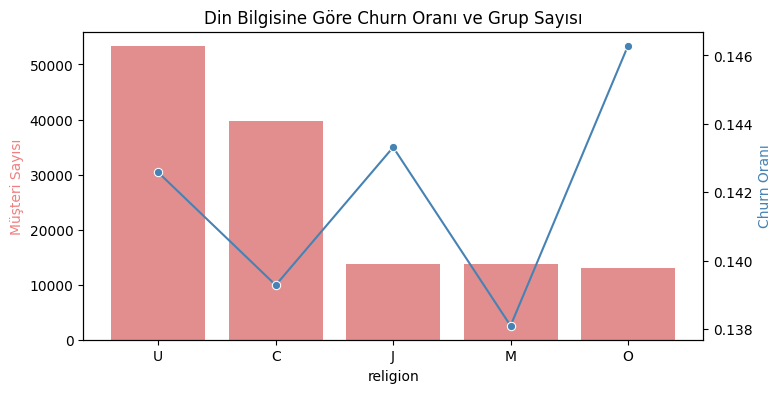

In [ ]:
# Religion churn + counts
religion_churn = (
    customers_df.merge(referance_train_df[['cust_id','churn']], on='cust_id')
    .groupby('religion')
    .agg(churn_rate=('churn','mean'), count=('cust_id','size'))
    .reset_index()
    .sort_values('count', ascending=False)
)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))

# Customer count as bar
sns.barplot(data=religion_churn, x='religion', y='count', color='lightcoral', ax=ax1)
ax1.set_ylabel('Müşteri Sayısı', color='lightcoral')

# Churn rate as line
ax2 = ax1.twinx()
sns.lineplot(data=religion_churn, x='religion', y='churn_rate', color='steelblue', marker='o', ax=ax2)
ax2.set_ylabel('Churn Oranı', color='steelblue')

plt.title("Din Bilgisine Göre Churn Oranı ve Grup Sayısı")
plt.show()

* İki büyük din grubunun müşteri sayısı yüksek ve churn oranları birbirine yakın olsa da küçük bir fark mevcut, bu da modele anlamlı katkı sağlayabilir.

### İş Tipi ve İş Sektörü

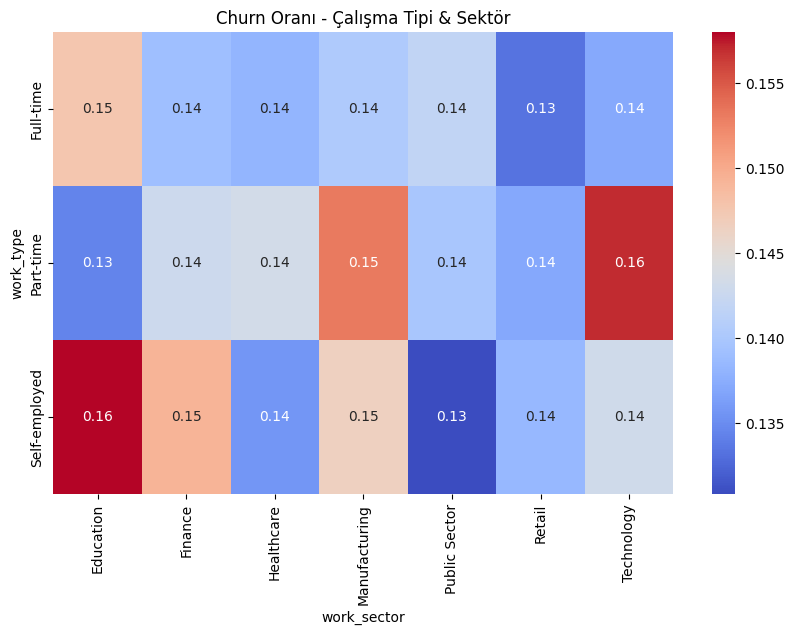

In [ ]:
work_churn = (
    customers_df.merge(referance_train_df[['cust_id', 'churn']], on='cust_id', how='inner')
    .groupby(['work_type', 'work_sector'])
    .agg(churn_rate=('churn', 'mean'), count=('cust_id', 'size'))
    .reset_index()
    .sort_values('count', ascending=False)
)

plt.figure(figsize=(10,6))
sns.heatmap(
    work_churn.pivot(index='work_type', columns='work_sector', values='churn_rate'),
    annot=True, fmt=".2f", cmap='coolwarm'
)
plt.title("Churn Oranı - Çalışma Tipi & Sektör")
plt.show()

* work_type ve work_sector arasında küçük farklılıklar var.
* Bu iki özellik, diğer demografik veya bölgesel bilgilerle (örn. province, age_group, tenure) birlikte kombinlenerek daha anlamlı sinyaller elde edilebilir.
* Bu sayede model, belirli iş türü ve sektör kombinasyonlarının churn üzerindeki etkisini daha iyi öğrenebilir.

### Müşterilik Süresi

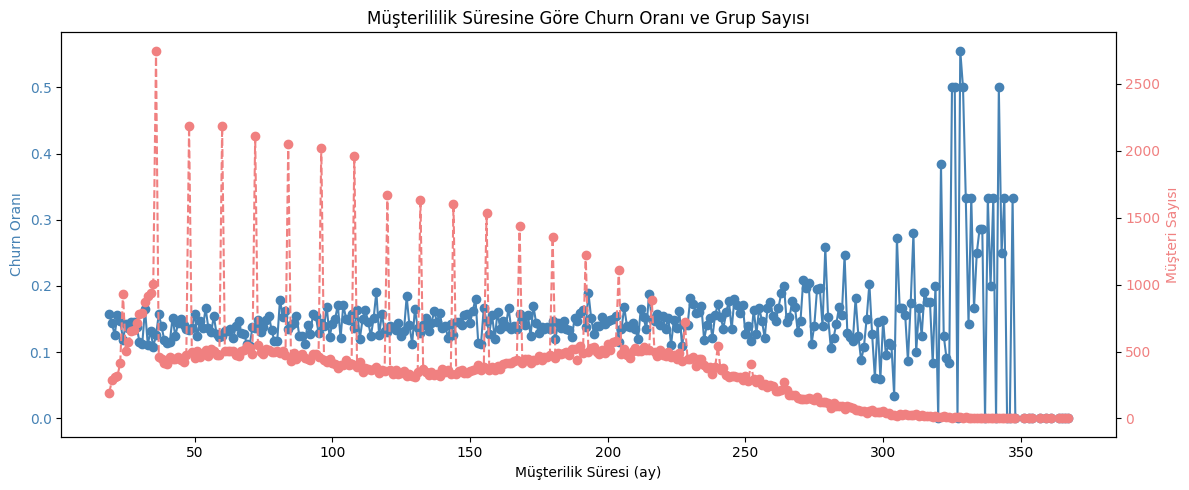

In [ ]:
# Merge churn
tenure_churn = customers_df.merge(referance_train_df[['cust_id','churn']], on='cust_id')

# Her tenure değeri için churn oranı ve müşteri sayısı
tenure_summary = tenure_churn.groupby('tenure').agg(
    churn_rate=('churn','mean'),
    count=('cust_id','size')
).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(12,5))

# Churn rate
ax1.plot(tenure_summary['tenure'], tenure_summary['churn_rate'], marker='o', color='steelblue', label='Churn Rate')
ax1.set_xlabel("Müşterilik Süresi (ay)")
ax1.set_ylabel("Churn Oranı", color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Customer count (right y-axis)
ax2 = ax1.twinx()
ax2.plot(tenure_summary['tenure'], tenure_summary['count'], marker='o', color='lightcoral', linestyle='--', label='Customer Count')
ax2.set_ylabel("Müşteri Sayısı", color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

plt.title("Müşterililik Süresine Göre Churn Oranı ve Grup Sayısı")
fig.tight_layout()
plt.show()

* Müşterilik süresi uzadıkça, o gruptaki müşteri sayısı hızla azalıyor.
* Daha uzun süreli müşterilerde churn oranı dalgalanmalar gösteriyor; bu nedenle kullanmak zor olabilir.

### 2li Kombinasyonların Churn Korelasyonu

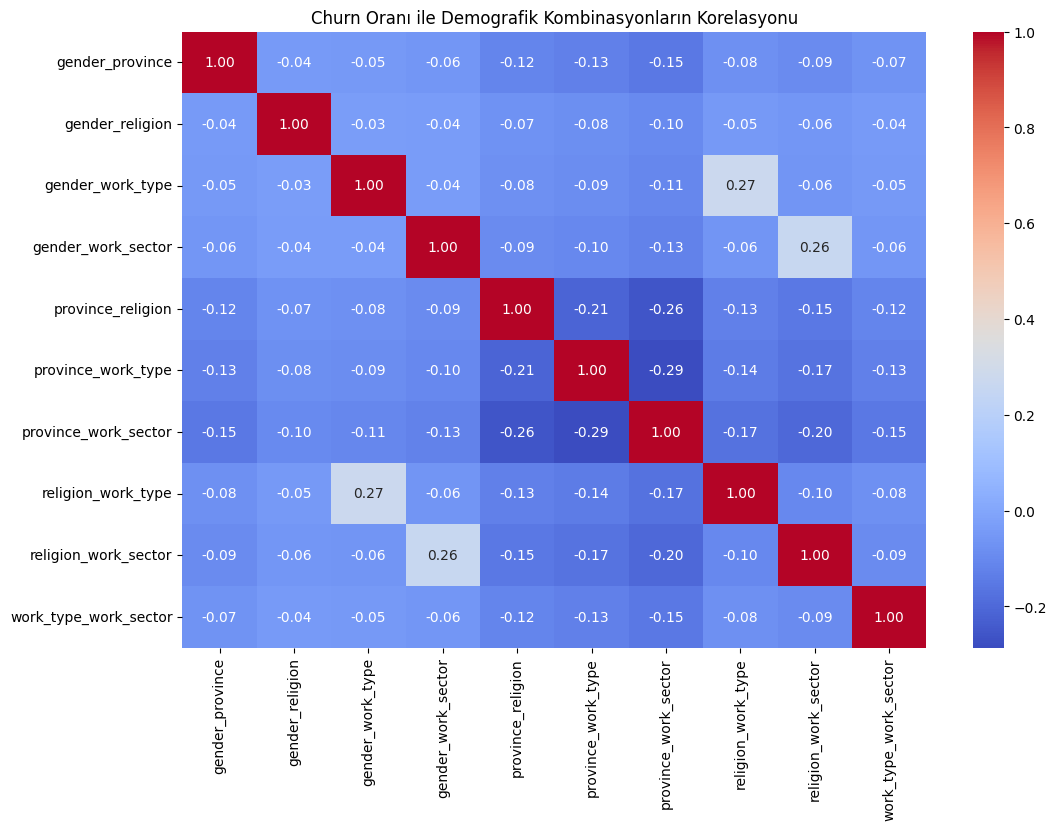

In [ ]:
# Kopya
df = customers_df.merge(referance_train_df[['cust_id','churn']], on='cust_id', how='inner')

# Pairwise combinations
comb_cols = ['gender', 'province', 'religion', 'work_type', 'work_sector']
for c1, c2 in combinations(comb_cols, 2):
    df[f'{c1}_{c2}'] = df[c1].astype(str).fillna('NA') + '-' + df[c2].astype(str).fillna('NA')

# Her kombinasyon için churn oranı
comb_churn = {}
for c1, c2 in combinations(comb_cols, 2):
    col = f'{c1}_{c2}'
    comb_churn[col] = df.groupby(col)['churn'].mean()

# DataFrame'e çevir ve korelasyon matrisi
comb_churn_df = pd.DataFrame(comb_churn).fillna(0)
corr_matrix = comb_churn_df.corr()

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Churn Oranı ile Demografik Kombinasyonların Korelasyonu")
plt.show()

* work_type ve work_sector özelliklerini religion ile birleştirerek, müşteri profilleri için daha anlamlı bir kategorik sütun oluşturabiliriz.

# 3. Train ve Test Veri setlerini oluşturma

* Statik Bilgilerde: gender (cinsiyet) ve tenure (müşteri süresi) gibi, tahminsel gücü düşük veya dağılımı sorunlu kabul edilen statik özellikler veri setinden atıldı.

* Ham Zaman Bilgisi: ref_date (referans tarihi), periyodik (yıl/ay) özellikler çıkarıldıktan sonra gereksizlikten silindi.

* Gereksiz Etkileşimler: gender içeren veya anlamı düşük bulunan ikili kategorik kombinasyonlar (örneğin gender_province) model boyutunu azaltmak için silindi.

* Uzun Süreli RFM Özetleri: Müşterinin tüm geçmişini kapsayan temel aktivite (Frequency) ve parasal değer (Monetary) metrikleri (total_months, total_eft_amount, avg_transaction_amount) korundu.

* Kısa Dönem Ortalama Aktivite: Churn sinyali için kritik olan son 3 ve 6 aylık ortalama işlem, harcama ve ürün sayısı gibi dönem odaklı özetler (last_3months_...) eklendi.

* Davranışsal Trend Sinyalleri: Son aydaki aktivite ile önceki ayların ortalaması arasındaki farkı gösteren trend metrikleri (transaction_trend_3months, product_trend_6months) korundu.

* Ham Aylık Gecikme (Lag) Değerleri: Kritik metriklerin son 7 aya ait aylık ham değerleri (Lag 0-6) zaman serisi bağımlılığını yakalamak için ayrı sütunlar olarak eklendi.

* Normalize Edilmiş Lag Dağılımı: Son 6 aylık toplam aktivite içindeki her ayın payını gösteren yüzdelik dağılımlar eklendi. Bu, farklı hacimlerdeki kullanıcılar arasındaki mutlak büyüklük farkını normalize etmemize yardımcı oldu.

* Anlamlı Kategorik Etkileşimler: Tahminsel gücü yüksek olması beklenen kategorik özellik çiftlerinin (örneğin province_work_type) kombinasyonları veri setine dahil edildi.

* Referans Zaman Dilimi: ref_date'den ayrıştırılan year ve month bilgileri, dönemsel etkiyi yakalamak için tutuldu.


Bazı özelliklerin düşürülmesi veya işlenmesiyle ilgili detaylı bilgi **4. Özellik Seçimi** kısmında verilmiştir

In [6]:
def build_base_features(
    referance_df,
    customers_df,
    customers_hist_df,
    is_test=False,
):
    """
    Build base features - each feature calculated independently from scratch.
    Based on RFM (Recency, Frequency, Monetary) framework.
    """

    # --- Copy dataframes ---
    df = referance_df.copy()
    customers = customers_df.copy()
    hist = customers_hist_df.copy()

    # Train veriseti mi?
    has_target = "churn" in df.columns
    if not is_test and not has_target:
        raise ValueError("Training data must contain 'churn' column")
    if is_test and has_target:
        print("Warning: Test data contains 'churn' column. Removing it.")
        df = df.drop(columns=['churn'])

    # Date veritiplerini çevirme işlemi
    df['ref_date'] = pd.to_datetime(df['ref_date'])
    hist['date'] = pd.to_datetime(hist['date'])

    # Veri tiplerini düzeltme
    numeric_cols_hist = [
        'mobile_eft_all_cnt', 'mobile_eft_all_amt',
        'cc_transaction_all_cnt', 'cc_transaction_all_amt',
        'active_product_category_nbr'
    ]
    for col in numeric_cols_hist:
        if col in hist.columns:
            hist[col] = pd.to_numeric(hist[col], errors='coerce').fillna(0)

    df = df.merge(customers, on='cust_id', how='left')

    # Null değerleri Unknown ile dolduruyoruz
    df['work_sector'] = df['work_sector'].fillna('Unknown')

    # Müşterinin işlem yaptığı toplam ay sayısı.
    temp = hist.groupby('cust_id')['date'].nunique().reset_index()
    temp.columns = ['cust_id', 'total_months']
    df = df.merge(temp, on='cust_id', how='left')

    # Müşterinin geçmişindeki aylık ortalama toplam işlem sayısı (mobil EFT ve kredi kartı dahil).
    temp = hist.groupby('cust_id').agg(
        total_trans=('mobile_eft_all_cnt', 'sum'),
        total_cc=('cc_transaction_all_cnt', 'sum'),
        months=('date', 'nunique')
    ).reset_index()
    temp['transactions_per_month'] = (temp['total_trans'] + temp['total_cc']) / (temp['months'] + 1e-6)
    df = df.merge(temp[['cust_id', 'transactions_per_month']], on='cust_id', how='left')

    # Müşterinin tüm geçmişindeki toplam mobil EFT işlem sayısı.
    temp = hist.groupby('cust_id')['mobile_eft_all_cnt'].sum().reset_index()
    temp.columns = ['cust_id', 'total_eft_transactions']
    df = df.merge(temp, on='cust_id', how='left')

    # Müşterinin tüm geçmişindeki tüm işlemleri (EFT ve KK) için ortalama işlem tutarı.
    temp = hist.groupby('cust_id').agg(
        total_amt=('mobile_eft_all_amt', 'sum'),
        total_cc_amt=('cc_transaction_all_amt', 'sum'),
        total_cnt=('mobile_eft_all_cnt', 'sum'),
        total_cc_cnt=('cc_transaction_all_cnt', 'sum')
    ).reset_index()
    temp['avg_transaction_amount'] = (temp['total_amt'] + temp['total_cc_amt']) / (temp['total_cnt'] + temp['total_cc_cnt'] + 1e-6)
    df = df.merge(temp[['cust_id', 'avg_transaction_amount']], on='cust_id', how='left')

    # Müşterinin tüm geçmişindeki toplam mobil EFT tutarı.
    temp = hist.groupby('cust_id')['mobile_eft_all_amt'].sum().reset_index()
    temp.columns = ['cust_id', 'total_eft_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Müşterinin tüm geçmişindeki toplam kredi kartı (CC) işlem tutarı.
    temp = hist.groupby('cust_id')['cc_transaction_all_amt'].sum().reset_index()
    temp.columns = ['cust_id', 'total_cc_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 3 aydaki ortalama toplam işlem sayısı (EFT ve KK ortalamalarının toplamı).
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id').agg(
        eft=('mobile_eft_all_cnt', 'mean'),
        cc=('cc_transaction_all_cnt', 'mean')
    ).reset_index()
    temp['last_3months_transactions'] = temp['eft'] + temp['cc']
    df = df.merge(temp[['cust_id', 'last_3months_transactions']], on='cust_id', how='left')

    # Son 6 aydaki ortalama toplam işlem sayısı (EFT ve KK ortalamalarının toplamı).
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id').agg(
        eft=('mobile_eft_all_cnt', 'mean'),
        cc=('cc_transaction_all_cnt', 'mean')
    ).reset_index()
    temp['last_6months_transactions'] = temp['eft'] + temp['cc']
    df = df.merge(temp[['cust_id', 'last_6months_transactions']], on='cust_id', how='left')

    # Son 3 aydaki ortalama toplam harcama tutarı (EFT ve KK tutar ortalamalarının toplamı).
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id').agg(
        eft_amt=('mobile_eft_all_amt', 'mean'),
        cc_amt=('cc_transaction_all_amt', 'mean')
    ).reset_index()
    temp['last_3months_spend'] = temp['eft_amt'] + temp['cc_amt']
    df = df.merge(temp[['cust_id', 'last_3months_spend']], on='cust_id', how='left')

    # Son 6 aydaki ortalama toplam harcama tutarı (EFT ve KK tutar ortalamalarının toplamı).
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id').agg(
        eft_amt=('mobile_eft_all_amt', 'mean'),
        cc_amt=('cc_transaction_all_amt', 'mean')
    ).reset_index()
    temp['last_6months_spend'] = temp['eft_amt'] + temp['cc_amt']
    df = df.merge(temp[['cust_id', 'last_6months_spend']], on='cust_id', how='left')

    # Son 3 aydaki aktif ürün kategorisi sayısının ortalaması.
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
    temp.columns = ['cust_id', 'last_3months_products']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 6 aydaki aktif ürün kategorisi sayısının ortalaması.
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
    temp.columns = ['cust_id', 'last_6months_products']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 3 aydaki aylık ortalama mobil EFT işlem sayısı.
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['mobile_eft_all_cnt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_3months_eft_count']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 6 aydaki aylık ortalama mobil EFT işlem sayısı.
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['mobile_eft_all_cnt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_6months_eft_count']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 3 aydaki aylık ortalama mobil EFT tutarı.
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['mobile_eft_all_amt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_3months_eft_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 6 aydaki aylık ortalama mobil EFT tutarı.
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['mobile_eft_all_amt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_6months_eft_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 3 aydaki aylık ortalama kredi kartı işlem sayısı.
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['cc_transaction_all_cnt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_3months_cc_count']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 6 aydaki aylık ortalama kredi kartı işlem sayısı.
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['cc_transaction_all_cnt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_6months_cc_count']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 3 aydaki aylık ortalama kredi kartı işlem tutarı.
    temp = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['cc_transaction_all_amt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_3months_cc_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Son 6 aydaki aylık ortalama kredi kartı işlem tutarı.
    temp = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['cc_transaction_all_amt'].mean().reset_index()
    temp.columns = ['cust_id', 'last_6months_cc_amount']
    df = df.merge(temp, on='cust_id', how='left')

    # Müşterinin işlem aktivitesindeki son 3 aylık trend. Son ayın işlem sayısı ile önceki iki ayın ortalamasının karşılaştırılmasına dayanır. Pozitif değer, aktivitenin arttığını gösterir.
    temp_last = hist.sort_values('date').groupby('cust_id').tail(1).groupby('cust_id').agg(
        last_eft=('mobile_eft_all_cnt', 'sum'),
        last_cc=('cc_transaction_all_cnt', 'sum')
    ).reset_index()
    temp_last['last_trans'] = temp_last['last_eft'] + temp_last['last_cc']

    temp_3m = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id').agg(
        eft_3m=('mobile_eft_all_cnt', 'sum'),
        cc_3m=('cc_transaction_all_cnt', 'sum')
    ).reset_index()
    temp_3m['trans_3m'] = temp_3m['eft_3m'] + temp_3m['cc_3m']

    temp = temp_last.merge(temp_3m, on='cust_id', how='outer')
    temp['transaction_trend_3months'] = temp['last_trans'] - (temp['trans_3m'] - temp['last_trans']) / 2
    df = df.merge(temp[['cust_id', 'transaction_trend_3months']], on='cust_id', how='left')

    # Müşterinin işlem aktivitesindeki son 6 aylık trend. Son ayın işlem sayısı ile önceki beş ayın ortalamasının karşılaştırılmasına dayanır. Pozitif değer, aktivitenin arttığını gösterir.
    temp_last = hist.sort_values('date').groupby('cust_id').tail(1).groupby('cust_id').agg(
        last_eft=('mobile_eft_all_cnt', 'sum'),
        last_cc=('cc_transaction_all_cnt', 'sum')
    ).reset_index()
    temp_last['last_trans'] = temp_last['last_eft'] + temp_last['last_cc']

    temp_6m = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id').agg(
        eft_6m=('mobile_eft_all_cnt', 'sum'),
        cc_6m=('cc_transaction_all_cnt', 'sum')
    ).reset_index()
    temp_6m['trans_6m'] = temp_6m['eft_6m'] + temp_6m['cc_6m']

    temp = temp_last.merge(temp_6m, on='cust_id', how='outer')
    temp['transaction_trend_6months'] = temp['last_trans'] - (temp['trans_6m'] - temp['last_trans']) / 2
    df = df.merge(temp[['cust_id', 'transaction_trend_6months']], on='cust_id', how='left')

    # Müşterinin sahip olduğu aktif ürün sayısındaki son 3 aylık trend. Son aydaki aktif ürün sayısı ile son 3 aydaki ortalama aktif ürün sayısının farkı. Pozitif değer, ürün sayısının arttığını gösterir.
    temp_last = hist.sort_values('date').groupby('cust_id').tail(1)[['cust_id', 'active_product_category_nbr']].reset_index(drop=True)
    temp_last.columns = ['cust_id', 'last_prod']

    temp_3m = hist.sort_values('date').groupby('cust_id').tail(3).groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
    temp_3m.columns = ['cust_id', 'avg_3m_prod']

    temp = temp_last.merge(temp_3m, on='cust_id', how='outer')
    temp['product_trend_3months'] = temp['last_prod'] - temp['avg_3m_prod']
    df = df.merge(temp[['cust_id', 'product_trend_3months']], on='cust_id', how='left')

    # Müşterinin sahip olduğu aktif ürün sayısındaki son 6 aylık trend. Son aydaki aktif ürün sayısı ile son 6 aydaki ortalama aktif ürün sayısının farkı. Pozitif değer, ürün sayısının arttığını gösterir.
    temp_last = hist.sort_values('date').groupby('cust_id').tail(1)[['cust_id', 'active_product_category_nbr']].reset_index(drop=True)
    temp_last.columns = ['cust_id', 'last_prod']

    temp_6m = hist.sort_values('date').groupby('cust_id').tail(6).groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
    temp_6m.columns = ['cust_id', 'avg_6m_prod']

    temp = temp_last.merge(temp_6m, on='cust_id', how='outer')
    temp['product_trend_6months'] = temp['last_prod'] - temp['avg_6m_prod']
    df = df.merge(temp[['cust_id', 'product_trend_6months']], on='cust_id', how='left')

    # Müşterinin tüm geçmişi boyunca sahip olduğu aktif ürün kategorisi sayısının ortalaması.
    temp = hist.groupby('cust_id')['active_product_category_nbr'].mean().reset_index()
    temp.columns = ['cust_id', 'avg_products']
    df = df.merge(temp, on='cust_id', how='left')

    # Geçen ay aktif miydi?
    temp = hist.sort_values('date').groupby('cust_id').tail(1)[['cust_id', 'mobile_eft_all_cnt', 'cc_transaction_all_cnt']].reset_index(drop=True)
    temp['inactive_last_month'] = ((temp['mobile_eft_all_cnt'] + temp['cc_transaction_all_cnt']) == 0).astype(int)
    df = df.merge(temp[['cust_id', 'inactive_last_month']], on='cust_id', how='left')

    # Özelliklerin hesaplandığı referans tarihin yılı (ref_date)
    df['year'] = df['ref_date'].dt.year

    # Özelliklerin hesaplandığı referans tarihin ayı (ref_date)
    df['month'] = df['ref_date'].dt.month

    df = df.drop(columns=['ref_date'])

    cc_count_lags = [0, 1, 2, 3, 4, 5, 6]
    cc_amount_lags = [0, 1, 2, 3, 4, 5, 6]
    eft_count_lags = [0, 1, 2, 3, 4, 5, 6]
    eft_amount_lags = [0, 1, 2, 3, 4, 5, 6]
    product_lags = [0, 1, 2, 3, 4, 5, 6]

    hist_sorted = hist.sort_values(['cust_id', 'date']).copy()

    # Mobil EFT, KK işlemi ve aktif ürün sayısı gibi metriklerin son [0] ile [6] ay önceki aylık değerleri. Örneğin, cc_transaction_all_cnt_lag1, bir ay önceki kredi kartı işlem sayısıdır.
    for lag in cc_count_lags:
      hist_sorted[f'lag_{lag}'] = hist_sorted.groupby('cust_id')['cc_transaction_all_cnt'].shift(lag)
      temp = hist_sorted.groupby('cust_id').tail(1)[['cust_id', f'lag_{lag}']].reset_index(drop=True)
      temp.columns = ['cust_id', f'cc_transaction_all_cnt_lag{lag}']
      df = df.merge(temp, on='cust_id', how='left')

    for lag in cc_amount_lags:
      hist_sorted[f'lag_{lag}'] = hist_sorted.groupby('cust_id')['cc_transaction_all_amt'].shift(lag)
      temp = hist_sorted.groupby('cust_id').tail(1)[['cust_id', f'lag_{lag}']].reset_index(drop=True)
      temp.columns = ['cust_id', f'cc_transaction_all_amt_lag{lag}']
      df = df.merge(temp, on='cust_id', how='left')

    for lag in eft_count_lags:
      hist_sorted[f'lag_{lag}'] = hist_sorted.groupby('cust_id')['mobile_eft_all_cnt'].shift(lag)
      temp = hist_sorted.groupby('cust_id').tail(1)[['cust_id', f'lag_{lag}']].reset_index(drop=True)
      temp.columns = ['cust_id', f'mobile_eft_all_cnt_lag{lag}']
      df = df.merge(temp, on='cust_id', how='left')

    for lag in eft_amount_lags:
      hist_sorted[f'lag_{lag}'] = hist_sorted.groupby('cust_id')['mobile_eft_all_amt'].shift(lag)
      temp = hist_sorted.groupby('cust_id').tail(1)[['cust_id', f'lag_{lag}']].reset_index(drop=True)
      temp.columns = ['cust_id', f'mobile_eft_all_amt_lag{lag}']
      df = df.merge(temp, on='cust_id', how='left')

    for lag in product_lags:
      hist_sorted[f'lag_{lag}'] = hist_sorted.groupby('cust_id')['active_product_category_nbr'].shift(lag)
      temp = hist_sorted.groupby('cust_id').tail(1)[['cust_id', f'lag_{lag}']].reset_index(drop=True)
      temp.columns = ['cust_id', f'active_product_category_nbr_lag{lag}']
      df = df.merge(temp, on='cust_id', how='left')

    # İlgili metriğin (EFT/KK işlem sayısı/tutarı) son [0] ile [5] ay içindeki toplam aktivite içindeki yüzde dağılımı. Örneğin, mobile_eft_cnt_lag0_perc, son 6 aydaki toplam EFT işlem sayısının yüzde kaçının en son ayda gerçekleştiğini gösterir.
    def add_lag_percentages(df, feature_prefix, lag_cols, num_lags=6):
        """
        Calculate percentage distribution of last N months for a lagged feature.

        Parameters:
        - df: DataFrame
        - feature_prefix: The prefix of the lag columns (e.g., 'cc_transaction_all_amt')
        - lag_cols: List of lag column names
        - num_lags: Number of lags to include in percentage calculation (default 6, for lag 0-5)
        """
        sum_col_name = f'{feature_prefix}_last{num_lags}m_sum'
        df[sum_col_name] = sum(df[f'{feature_prefix}_lag{i}'] for i in range(num_lags))

        for i in range(num_lags):
            lag_col = f'{feature_prefix}_lag{i}'
            perc_col = f'{feature_prefix.replace("_all_", "_")}_lag{i}_perc'
            df[perc_col] = (df[lag_col] / (df[sum_col_name] + 1e-6)) * 100

        df = df.drop(columns=[sum_col_name])

        return df

    # Tüm harcamalar için yüzdelerin eklenmesi
    df = add_lag_percentages(df, 'cc_transaction_all_cnt', cc_count_lags)
    df = add_lag_percentages(df, 'cc_transaction_all_amt', cc_amount_lags)
    df = add_lag_percentages(df, 'mobile_eft_all_cnt', eft_count_lags)
    df = add_lag_percentages(df, 'mobile_eft_all_amt', eft_amount_lags)

    # İkili etkileşimler
    comb_cols = ['gender', 'province', 'religion', 'work_type', 'work_sector']
    for c1, c2 in combinations(comb_cols, 2):
        new_col = f'{c1}_{c2}'
        df[new_col] = (
            df[c1].astype(str).fillna('NA') + '-' +
            df[c2].astype(str).fillna('NA')
        )
    # Sadece religion - work_type ve religion - work_sector bilgilerini tutuyoruz
    cols_to_drop = ['gender_province', 'gender_religion', 'gender_work_type', 'gender_work_sector', 'province_religion', 'province_work_type', 'province_work_sector', 'work_type_work_sector']
    df = df.drop(cols_to_drop, axis=1)

    # Geri kalanları sıfırları dolduruyoruz
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    df = df.drop(columns="gender")
    df = df.drop(columns="tenure")

    return df

In [7]:
# Veri tipi düzeltmesi ve cust_id sütununu indexleme işlemi
def revise_cols(df):
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    df[cat_cols] = df[cat_cols].astype('category')

    if 'cust_id' in df.columns:
        df = df.set_index('cust_id')
    return df

In [8]:
# Son Feature'ları ile datasetleri oluşturuyoruz
train_df_final = build_base_features(
    referance_train_df,
    customers_df,
    customers_hist_df,
    is_test=False
)
test_df_final = build_base_features(
    referance_test_df,
    customers_df,
    customers_hist_df,
    is_test=True
)

train_df_final = revise_cols(train_df_final)
test_df_final = revise_cols(test_df_final)

# 4. Özellik Seçimi

## 4.1 Welch's T-test

Welch’s t-testi, iki nümerik veri grubunun ortalamaları arasında anlamlı bir fark olup olmadığını test eden bir istatistiksel yöntemdir. <br>
İki sınıf (Churn olan ve olmayan) arasında ortalama değer farkının istatistiksel olarak anlamlı olup olmadığını ölçeceğiz, böylece sınıfları birbirinden iyi ayıran, yani ayırıcı gücü yüksek özellikleri belirlemeye yardımcı . <br>
Eğer ayırıcı güç düşükse o özelliğin değeri bizim için azalabilmektedir

In [ ]:
def welch_ttest_feature_selection(df, features, target_col):
    """
    Compute t-test statistics for feature selection in binary classification.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset
    features : list
        List of feature column names to evaluate
    target_col : str
        Name of the binary target column

    Returns:
    --------
    pandas.DataFrame
        DataFrame with features ranked by absolute t-statistic
    """
    results = []

    # Get unique classes
    classes = df[target_col].unique()
    if len(classes) != 2:
        raise ValueError("Target must be binary (exactly 2 classes)")

    class_A, class_B = classes

    for feature in features:
        # Split data by class (Churn or not)
        group_A = df[df[target_col] == class_A][feature].dropna()
        group_B = df[df[target_col] == class_B][feature].dropna()

        # Calculate statistics
        mu_A = group_A.mean()
        mu_B = group_B.mean()
        sigma_A = group_A.std(ddof=1)
        sigma_B = group_B.std(ddof=1)
        n_A = len(group_A)
        n_B = len(group_B)

        # Calculate standard error
        se = np.sqrt((sigma_A**2 / n_A) + (sigma_B**2 / n_B))

        # Calculate t-statistic
        if se == 0:
            t_stat = 0
        else:
            t_stat = abs(mu_A - mu_B) / se

        results.append({
            'feature': feature,
            'abs_t_statistic': abs(t_stat),
            'mean_class_0': mu_A,
            'mean_class_1': mu_B,
            'mean_difference': abs(mu_A - mu_B),
            'std_class_0': sigma_A,
            'std_class_1': sigma_B,
            'std_difference': abs(sigma_A - sigma_B)
        })

    # Create DataFrame and sort by absolute t-statistic
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('abs_t_statistic', ascending=False).reset_index(drop=True)

    return results_df

In [ ]:
welch_ttest_df = welch_ttest_feature_selection(train_df_final, train_df_final.select_dtypes(include=['number']).columns, 'churn')
welch_ttest_df.head(20)

,feature,abs_t_statistic,mean_class_0,mean_class_1,mean_difference,std_class_0,std_class_1,std_difference
0,avg_products,85.317054,2.725638,2.452048,0.273589,0.442774,0.402132,0.040642
1,last_3months_products,81.656039,2.689495,2.393906,0.295590,0.500362,0.453851,0.046511
2,last_6months_products,80.534499,2.709638,2.425623,0.284015,0.482925,0.442974,0.039951
3,active_product_category_nbr_lag0,78.478274,2.684977,2.380498,0.304479,0.531053,0.487374,0.043679
4,active_product_category_nbr_lag1,75.459133,2.683605,2.389666,0.293939,0.530838,0.489748,0.041090
5,active_product_category_nbr_lag2,73.480284,2.699905,2.411553,0.288352,0.528501,0.494491,0.034010
6,active_product_category_nbr_lag3,70.539276,2.715261,2.436831,0.278430,0.525454,0.498458,0.026996
7,active_product_category_nbr_lag4,68.281377,2.729149,2.458771,0.270378,0.522467,0.500856,0.021610
8,active_product_category_nbr_lag5,67.693507,2.744933,2.476418,0.268515,0.518705,0.502525,0.016180
9,active_product_category_nbr_lag6,67.297100,2.743237,2.476047,0.267191,0.519552,0.502929,0.016624


## 4.2 Leave one Feature Out (LOFO)

İstatistiksel yöntemler ve feature importance gibi metodlar tek başına feature'ın önemi hakkında kesin bir sonuç çıkartmayabilir <br>
Sektörde en çok kullanılan yöntemlerden birisi ise LOFO'dur, ilgili feature'ı veriden tamamen atıp modelin performansının nasıl değiştiğini gözlemleriz.

Tabii bazı feature'lar birbirlerine bağlı olabileceğinden dolayı feature gruplama yoluna da başvurarak LOFO'yu daha efektif uygulayabilirsiniz - <br>
Bunun için, Ahmet Erdem'in geliştirdiği https://github.com/aerdem4/lofo-importance kütüphanesini kullanmanızı öneririz

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from catboost import CatBoostClassifier, Pool
from custom_score import ing_hubs_datathon_metric

In [ ]:
def train_catboost(train_df, test_df=None, params=None, n_folds=10, val_size=0.05, early_stopping_rounds=100, verbose=True, use_gpu=True):
    """
    Train CatBoost model using StratifiedKFold cross-validation or full training.

    Parameters:
    -----------
    train_df : pd.DataFrame
        Training dataframe with features and 'churn' target column
    test_df : pd.DataFrame, default=None
        Test dataframe for full training mode. If provided, performs single training instead of CV.
    params : dict, default = None
        Model hyperparameters
    n_folds : int, default=10
        Number of cross-validation folds
    val_size : float, default=0.05
        Validation set size for early stopping
    early_stopping_rounds : int, default=100
        Number of rounds for early stopping
    verbose: bool, default=True
        Whether to print scores or not
    use_gpu: bool, default=True
        Use GPU
    """
    # Identify categorical columns
    cat_cols = list(train_df.select_dtypes(include=['category']).columns)

    # Prepare features and target
    X = train_df.drop(columns='churn')
    y = train_df['churn']

    if params is None:
        params = {}

    if use_gpu:
        params['task_type'] = 'GPU'
    else:
        params['task_type'] = 'CPU'

    params['thread_count'] = -1
    params['verbose'] = 0
    params['random_state'] = 42

    # Full training mode
    if test_df is not None:
        # Create pools
        train_pool = Pool(X, y, cat_features=cat_cols)

        # Prepare test data
        X_test = test_df.drop(columns='churn', errors='ignore')

        # Train model
        model = CatBoostClassifier(**params)
        model.fit(train_pool)

        # Predict on test set
        y_test_probs = model.predict_proba(X_test)[:, 1]

        # Create DataFrame with single column
        y_probs_df = pd.DataFrame({'fold_1': y_test_probs}, index=X_test.index)

        if verbose:
            print("Full training completed")

        return model, y_probs_df

    # Cross-validation mode with StratifiedKFold
    else:
        cv = StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
        cv_scores = []
        oof_predictions = np.zeros(len(X))

        for fold_no, (idx_train, idx_test) in enumerate(cv.split(X, y), 1):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]

            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
            )

            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            valid_pool = Pool(X_val, y_val, cat_features=cat_cols)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=early_stopping_rounds)

            y_test_probs = model.predict_proba(X_test)[:, 1]

            oof_predictions[idx_test] = y_test_probs
            cv_score = ing_hubs_datathon_metric(y_test, y_test_probs)
            cv_scores.append(cv_score)

            if verbose:
                print(f"Fold No: {fold_no}  | Score: {round(cv_score, 3)}")

        # Calculate overall CV and OOF scores
        cv_score = np.mean(cv_scores)
        oof_score = ing_hubs_datathon_metric(y, oof_predictions)

        if verbose:
            print(25*'*')
            print(f"CV Score: {round(cv_score, 3)}")
            print(f"OOF Score: {round(oof_score, 3)}")

        return model, cv_score, oof_score

In [ ]:
cols_to_test = [col for col in list(train_df_final.columns) if col != 'churn']

# Metodu gösterebilmek ve Kaggle notebook'un da hızlı çalışması için 94 feature yerine sadece random 2 feature ile çalıştıralım
cols_to_test = random.sample(cols_to_test, 2)

lofo_experiment_result = []
for col in tqdm(cols_to_test, desc="LOFO in progress..."):
    train_df_exp = train_df_final.drop(columns=col).copy()
    model, cv_score, oof_score = train_catboost(train_df_exp, use_gpu=USE_GPU, verbose=False)
    lofo_experiment_result.append({f"{col}": round((cv_score+oof_score)/2, 6)}) # Başarı metriği olarak CV ve OOF skorlarının ortalamasını almayı tercih ettik

# Default değerimiz 1.187 geliyordu, bu değere göre LOFO sonuçlarını karşılaştırdık
lofo_experiment_result

LOFO in progress...: 100%|██████████| 2/2 [04:20<00:00, 130.21s/it]


[{'month': np.float64(1.177864)},
 {'cc_transaction_cnt_lag5_perc': np.float64(1.178447)}]

In [ ]:
lofo_experiment_result_df = pd.DataFrame([
    {'feature': list(d.keys())[0],
     'lofo_score': list(d.values())[0]}
    for d in lofo_experiment_result
])

# Welch's t-test'i ile LOFO sonuçlarını tek bir dataframe'de birleştirelim
hybrid_feature_selection_df = pd.merge(welch_ttest_df, lofo_experiment_result_df, on='feature', how='right')
hybrid_feature_selection_df.head(10)

,feature,abs_t_statistic,mean_class_0,mean_class_1,mean_difference,std_class_0,std_class_1,std_difference,lofo_score
0,month,4.550891,7.505843,7.387970,0.117872,3.309864,3.294288,0.015576,1.177864
1,cc_transaction_cnt_lag5_perc,5.875180,16.315207,16.831299,0.516092,11.214656,11.174323,0.040333,1.178447


### Özellik Seçimi Sonucu

Özellikle yarışma başlarında hem ham veriler hem de çıkardığımız temel özellikleri, oluşturduğumuz bu tablo üzerinden değerlendirerek çıkarma veya revize etme işlemleri gerçekleştirdik. <br>
Ham verilerde Gender ve Tenure özelliklerini bu nedenle kaldırdık

# 5. Modelleme

Default Catboost yarışmanın son günlerine kadar bizi yüksek sıralamalarda tuttu, paralelde ise Optuna ile Catboost'u tune ettik ve AutoGluon ile ileri seviye modelleme gerçekleştirdik <br> <br>
Modellemelerimizin private skorları:
* **Default Catboost:** 1.25155 (GPU kullanılırsa)
* **Tuned Catboost (Optuna'yla):** 1.22423 **(2.final submission seçimimiz)**
* **AutoGluon WeightedEnsemble_L5** (6 saat V6e-1 TPU): 1.26459 **(1.final submission seçimimiz)**

**NOT:** Eğitimleri Colab'de V6e-1 ile gerçekleştirdik. Kaggle'da V6e-1 olmadığı için AutoGluon'u aynı süreyle V5e-1 TPU ile çalıştırdığımızda private'da 1.26000 skoru alabildik. Aynı sürede daha güçlü işlemci gücüyle daha iyi model araması ve optimizasyonu yapılabildiğinden dolayı skorun düşmesi normaldir. <br>

Giriş kısmında bahsedildiği gibi bu notebook'da AutoGluon 6 dakika çalıştırılmıştır, Colab'de belirtilen TPU ile 6 saat çalıştırarak 'WeightedEnsemble_L5' modeliyle iyi skora yaklaşabilirsiniz
- **V5e-1:** 24 vCPUs, 197 TFLOPs
- **V6e-1:** 44 vCPUs, 918 TFLOps

In [11]:
import optuna
from autogluon.tabular import TabularPredictor
from autogluon.core.metrics import make_scorer

## 5.1 Default CatBoost

In [ ]:
model, cv_score, oof_score = train_catboost(train_df_final, use_gpu=USE_GPU)
# GPU kullanıldığında skorlar daha iyileşmekte, CV: 1.184, OOF: 1.19 olmaktadır (Final submission'da AutoGluon en iyi skoru getirdiği için onu en verimli çalıştıran TPU'yu kullanıyoruz)

Fold No: 1  | Score: 1.185
Fold No: 2  | Score: 1.171
Fold No: 3  | Score: 1.198
Fold No: 4  | Score: 1.156
Fold No: 5  | Score: 1.121
Fold No: 6  | Score: 1.174
Fold No: 7  | Score: 1.2
Fold No: 8  | Score: 1.192
Fold No: 9  | Score: 1.209
Fold No: 10  | Score: 1.132
*************************
CV Score: 1.174
OOF Score: 1.174


## 5.2 CatBoost Optuna Tuning

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 700, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 30.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.001, 20.0, log=True),
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain", "Ordered"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "task_type": "GPU" if USE_GPU else "CPU",
        "gpu_ram_part": 0.95,
        "verbose": 0,
        "random_state": 42
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample_bernoulli", 0.5, 1.0)
    elif params["bootstrap_type"] == "MVS":
        params["subsample"] = trial.suggest_float("subsample_mvs", 0.5, 1.0)

    if params["boosting_type"] == "Plain":
        params["score_function"] = trial.suggest_categorical("score_function", ["Cosine", "L2"])

    _, cv_score, oof_score = train_catboost(
        train_df_final,
        params=params,
        verbose=False,
        use_gpu=USE_GPU,
        early_stopping_rounds=150
    )
    return (cv_score + oof_score) / 2


study = optuna.create_study(
    study_name="ing_datathon",
    direction="maximize",
    sampler=optuna.samplers.TPESampler( # İlk 10 denemeyi random seçer ve iyi/kötü olanlara bakarak sonrasındaki trial'larda iyilerin hiperparametrelerine benzer şekilde ilerler
        seed=42,
        n_startup_trials=10,
        multivariate=True,
        group=True
    ),
    storage=None # Kaggle'da dosya yazma işlemine izin vermediği için bu parametreyi aşağıda açıkladık
)

"""
create_study fonksiyonuna storage="sqlite:///optuna_study.db" # Optuna study'i db şeklinde kaydederek checkpoint'ler şeklinde çalıştırabilirsiniz

Kaldığınız yerden devam etmek için:

study = optuna.load_study(
    study_name="ing_datathon",
    storage="sqlite:///optuna_study.db"
)

completed = len(study.trials)
remaining = 200 - completed

study.optimize(objective, n_trials=remaining, timeout=3600, show_progress_bar=True, n_jobs=1)
"""

[I 2025-10-24 08:16:49,513] A new study created in memory with name: ing_datathon


'\ncreate_study fonksiyonuna storage="sqlite:///optuna_study.db" #\xa0Optuna study\'i db şeklinde kaydederek checkpoint\'ler şeklinde çalıştırabilirsiniz\n\nKaldığınız yerden devam etmek için:\n\nstudy = optuna.load_study(\n    study_name="ing_datathon",\n    storage="sqlite:///optuna_study.db"\n)\n\ncompleted = len(study.trials)\nremaining = 200 - completed\n\nstudy.optimize(objective, n_trials=remaining, timeout=3600, show_progress_bar=True, n_jobs=1)\n'

In [ ]:
study.optimize(objective, n_trials=2, show_progress_bar=True, timeout=3600, n_jobs=1)
# Kaggle Notebook'da hızlı bitmesi için 2 trial olarak başlatalım, normalde 100-150'ye çekilebilir

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-24 08:25:08,154] Trial 0 finished with value: 1.1597789474831366 and parameters: {'iterations': 1187, 'learning_rate': 0.1667521176194013, 'depth': 8, 'l2_leaf_reg': 3.0405325392865645, 'random_strength': 0.004688574837063985, 'border_count': 128, 'min_data_in_leaf': 61, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient', 'bagging_temperature': 5.247564316322379, 'score_function': 'Cosine'}. Best is trial 0 with value: 1.1597789474831366.
[I 2025-10-24 08:33:58,449] Trial 1 finished with value: 1.163024277498847 and parameters: {'iterations': 1496, 'learning_rate': 0.008364645453054504, 'depth': 5, 'l2_leaf_reg': 0.8082071885709252, 'random_strength': 0.09153152164233955, 'border_count': 32, 'min_data_in_leaf': 60, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'leaf_estimation_iterations': 10, 'leaf_estimation_method': 'Newton', 'subsample_mvs': 0.5488360570031919}. Best is trial 1 with value: 

Ne kadar Optuna ile detaylı bir tuning işlemi yapmış ve CV-OOF'yi beraber kullanıp maximize etmeye çalışmış olsakta, early stopping ile birlikte public overfitting'e girmiş, genelleyemeyen bir modele dönüştüğü için stabil olmayan private skorlar çıkarmıştır <br>


## 5.3 AutoGluon

In [13]:
ag_custom_scorer = make_scorer(
    name='ing_hubs_datathon_metric',
    score_func=ing_hubs_datathon_metric,
    optimum=2,
    greater_is_better=True,
    needs_proba=True
)

In [14]:
predictor = TabularPredictor(
    problem_type='binary',
    label="churn",
    eval_metric=ag_custom_scorer
).fit(
    train_df_final,
    time_limit=360, # bu notebook'da 6 dakika çalıştırılmıştır ve sebebi hem 'Giriş' hem de 'Modelleme' başlıklarında açıklanmıştır, 21600 yaparak 6 saatlik runtime başlatabilirsiniz
    presets="best_quality",
    refit_full='best',
    num_stack_levels=3,
    num_bag_folds=10
)

No path specified. Models will be saved in: "AutogluonModels/ag-20251024_092808"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          44
Memory Avail:       168.68 GB / 172.95 GB (97.5%)
Disk Space Avail:   195.82 GB / 225.33 GB (86.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_st

In [15]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,1.197869,ing_hubs_datathon_metric,2.086485,180.716411,0.053056,11.882950,2,True,10
1,CatBoost_BAG_L1,1.187416,ing_hubs_datathon_metric,0.123632,64.026440,0.123632,64.026440,1,True,5
2,NeuralNetFastAI_BAG_L1,1.154292,ing_hubs_datathon_metric,1.274048,93.267391,1.274048,93.267391,1,True,8
3,XGBoost_BAG_L1,1.151602,ing_hubs_datathon_metric,0.519995,7.452662,0.519995,7.452662,1,True,9
4,LightGBM_BAG_L1,1.129626,ing_hubs_datathon_metric,0.115754,4.086968,0.115754,4.086968,1,True,2
5,LightGBMXT_BAG_L1,1.109381,ing_hubs_datathon_metric,0.148652,5.292903,0.148652,5.292903,1,True,1
6,RandomForestEntr_BAG_L1,1.107372,ing_hubs_datathon_metric,5.925608,12.931949,5.925608,12.931949,1,True,4
7,ExtraTreesGini_BAG_L1,1.102594,ing_hubs_datathon_metric,5.726617,2.980707,5.726617,2.980707,1,True,6
8,ExtraTreesEntr_BAG_L1,1.096174,ing_hubs_datathon_metric,5.953060,2.992317,5.953060,2.992317,1,True,7
9,RandomForestGini_BAG_L1,1.061256,ing_hubs_datathon_metric,6.182653,11.765214,6.182653,11.765214,1,True,3


In [16]:
predictor.feature_importance(data=train_df_final)
# runtime 6 dakika olduğu için burada gelecek değerler kesinlik sağlamayabilir, en iyi sonuçlar için belirtilen ortam şartlarında çalıştırınız

Computing feature importance via permutation shuffling for 94 features using 5000 rows with 5 shuffle sets...
	490.28s	= Expected runtime (98.06s per shuffle set)
	288.05s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
avg_products,0.450752,0.046051,0.000013,5,0.545571,0.355933
total_months,0.058370,0.015308,0.000519,5,0.089889,0.026851
mobile_eft_amt_lag4_perc,0.026174,0.015584,0.009925,5,0.058261,-0.005913
transactions_per_month,0.025758,0.034666,0.085978,5,0.097137,-0.045620
transaction_trend_3months,0.024544,0.024736,0.045371,5,0.075476,-0.026388
...,...,...,...,...,...,...
product_trend_3months,-0.000276,0.002152,0.605712,5,0.004155,-0.004706
mobile_eft_all_cnt_lag3,-0.000713,0.003749,0.653828,5,0.007006,-0.008432
inactive_last_month,-0.002599,0.004525,0.865829,5,0.006718,-0.011916
active_product_category_nbr_lag5,-0.002937,0.010682,0.714062,5,0.019056,-0.024931


# 6. Test Verisini Tahminleme

In [17]:
y_probs = predictor.predict_proba(test_df_final, model = "WeightedEnsemble_L2")
# Runtime süreniz ve model arama/optimizasyon sonuçlarına göre en iyi modeliniz değişebilir (Mesela 6 dakikalık runtime'da L2 çıkmış bu session'da, bu nedenle şimdi onu kullanalım) -
# Bu kod hücresinin hata vermesi durumunda model parametresini silerek Autogluon'un en iyi modeli seçerek prediction yapmasını sağlayabilirsiniz
# 6 saat runtime'da her zaman L5'in geldiğini gözlemledik.

In [18]:
# Create submission DataFrame
submission = pd.DataFrame({
    'cust_id': test_df_final.index,
    'churn': y_probs.iloc[:, 1].values
})

# **DİKKAT**: Private için en iyi modelin V6e-1 TPU ile 6 saat çalıştırılmış WeightedEnsemble_L5 olduğunu hatırlatırız.
submission.to_csv('submission.csv', index=False)

# 7. Denenen Ekstra Yöntemler ve Gözlemler

- **Data Augmentation (Son 6 aylık periyotların çıkarma)**
Churn tahmini sonraki 6 ay için yapıldığı ve son 6 ayda verisi bulunan müşterilerin dolayısıyla churn olmayacağı için, churn olan müşterilerin son 6 aylık verilerini çıkarıp yeni bir customer_id ile churn değerini 0 yaparak veri setine ekledik. Aynı yaklaşımı test setinde de uyguladık ve ayrıca yine churn olmayan müşterilerde sondan başlayarak 6’şar aylık periyotlar halinde veriyi parçalayarak yeni örnekler oluşturmayı denedik. Ancak hiçbirinde model performansında iyileşme gözlemlenmedi.

- **Harcamaların dolara indekslenmesi (enflasyon düzeltmesi)**
Yıllar arasındaki enflasyon farkını minimize etmek için tüm harcamaları dolara endeksledik. Skorlarda herhangi bir iyileşme olmadı.

- **Harcamaları Tüfe’ye oranlamak**
Harcama miktarlarını Tüfe’ye oranlayarak normalize etmeyi denedik. Ancak burada da model performansında artış görülmedi.

- **Farklı periyot kullanımları (6-12-18)**
Tahmin periyodu 6 ay olmasına rağmen, tüm müşterilerde en az 19 aylık veri olduğu için farklı periyot uzunluklarını (6, 12, 18, 19 ay) da denedik, bir iyileşme olmadı

- **Sabit periyotlu veri kullanımı (son 19 ay)**
Tüm müşteriler için periyodu sabitleyip yalnızca son 19 ayı kullanarak veri setini güncelledik. Ancak bu deneme de model performansını zayıflattı.